# Оценка качества вин

In [1]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import pandas as pd
import statsmodels.stats.api as sm

%pylab inline

C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It

Populating the interactive namespace from numpy and matplotlib


P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. **Modeling wine preferences by data mining from physicochemical properties.** *Decision Support Systems*, 47(4):547-553, 2009: имеются оценки качества 6497 португальских вин Vinho Verde, выставленные дегустаторами при слепом тестировании в баллах по шкале от 0 до 10. 

Прочитаем данные:

In [2]:
wine = pd.read_csv('wine_data.csv', sep='\t', header=0)
wine = wine.sample(frac=1)

Вот так выглядит распределение экспертных оценок вин в выборке:

Text(0.5, 0, 'Quality')

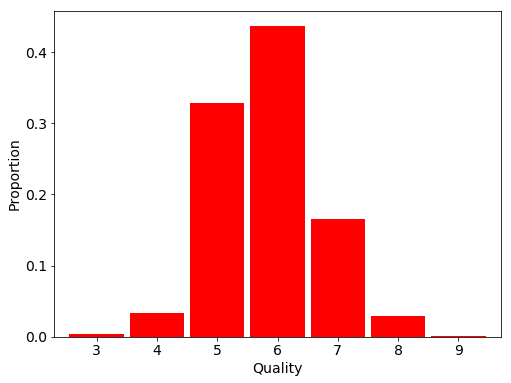

In [3]:
plt.figure(figsize(8,6))
stat = wine.groupby('quality')['quality'].agg(lambda x : float(len(x))/wine.shape[0])
stat.plot(kind='bar', fontsize=14, width=0.9, color="red")
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

In [8]:
#print(wine[['Type', 'quality']].info())
print(wine.ix[:, wine.columns != 'quality'].head())

       Type  Fixed acidity (g/l)  Volatile acidity (g/l)  Citric acid (g/l)  \
937     red                 12.0                    0.63               0.50   
2591  white                  6.5                    0.25               0.27   
1431    red                  7.6                    0.43               0.31   
2638  white                  7.5                    0.17               0.34   
2760  white                  7.8                    0.30               0.29   

      Residual sugar (g/l)  Chlorides (g/l)  Free sulfur dioxide  (mg/l)  \
937                   1.40            0.071                          6.0   
2591                 15.20            0.049                         75.0   
1431                  2.10            0.069                         13.0   
2638                  1.40            0.035                         13.0   
2760                 16.85            0.054                         23.0   

      Total sulfur dioxide (mg/l)  Density (g/cm3)    pH  Sulphates 

C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Давайте научимся оценивать этот признак, чтобы мы могли заранее предположить, какую оценку получит какое-то новое вино, которого в выборке нет. 
Чтобы смоделировать такую ситуацию, отделим 25% выборки для контроля качества предсказания:

In [12]:
#X_train, X_test, y_train, y_test = train_test_split(wine.ix[:, wine.columns != 'quality'], wine['quality'], test_size=0.25, stratify=wine[['Type', 'quality']])
X_train, X_test, y_train, y_test = train_test_split(wine.ix[:, wine.columns != 'quality'], wine['quality'], test_size=0.25)


C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [13]:
X_train['Type'] = X_train['Type'].apply(lambda x : -1 if x == 'red' else 1)
X_test['Type'] = X_test['Type'].apply(lambda x : -1 if x == 'red' else 1)

Если у нас нет больше никакой информации о винах, то наше лучшее предположение об оценке — среднее имеющихся в обучающей выборке:

In [14]:
np.mean(y_train)

5.818144499178982

Если мы будем предсказывать этой величиной оценку всех вин, на обучающей выборке мы получим среднеквадратичную ошибку

In [15]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_train), y_train))

0.8649435028903546

а на тестовой

In [16]:
sqrt(mean_squared_error([np.mean(y_train)]*len(y_test), y_test))

0.8974528153640491

На тестовой выборке ошибка больше, поскольку среднее мы оценивали по обучающей. Это естественный эффект.

# Тип вина

Какая-то ещё информация у нас есть, например, о типе вина:

In [17]:
wine.groupby('Type')['Type'].count()

Type
red      1599
white    4898
Name: Type, dtype: int64

Распределения оценок по типам довольно сильно отличаются:

Text(0.5, 0, 'Quality')

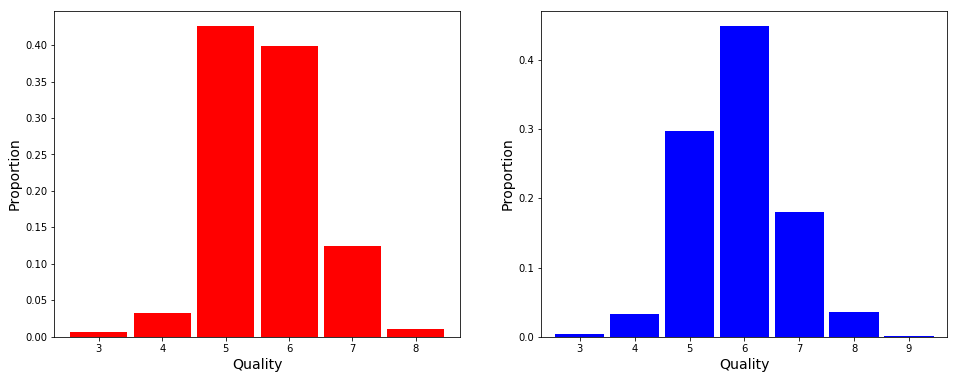

In [36]:
plt.figure(figsize(16,6))
plt.subplot(121)
stat_red = wine[wine['Type'] == 'red'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'red'].shape[0])
stat_red.plot(kind='bar', color='r', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

plt.subplot(122)
stat_white = wine[wine['Type'] == 'white'].groupby('quality')['quality'].agg(lambda x: float(len(x))/wine[wine['Type'] == 'white'].shape[0])
stat_white.plot(color='blue', kind='bar', width=0.9)
plt.xticks(rotation=0)
plt.ylabel('Proportion', fontsize=14)
plt.xlabel('Quality', fontsize=14)

Различие между средними статистически значимо:

In [20]:
tmeans = sm.CompareMeans(sm.DescrStatsW(wine[wine['Type'] == 'white']['quality']), 
                         sm.DescrStatsW(wine[wine['Type'] == 'red']['quality']))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

4.888069044201508e-22

95% доверительный интервал для разности средних оценок:

In [21]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.19293009404017963, 0.290843579328052)

Чтобы уточнить наше предсказание, можно оценку каждого вина предсказывать средним по оценкам вин такого же типа в выборке:

In [24]:
regressor = LinearRegression()
regressor.fit(X_train['Type'].values.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
y_train_predictions = regressor.predict(X_train['Type'].values.reshape(-1,1))

In [27]:
y_test_predictions = regressor.predict(X_test['Type'].values.reshape(-1,1))

Ошибки предсказания немного уменьшились:

In [28]:
sqrt(mean_squared_error(y_train_predictions, y_train))

0.8581306932917553

In [29]:
sqrt(mean_squared_error(y_test_predictions, y_test))

0.8928954077714295

Вот так выглядят истинные оценки вин и их предсказания средними по типам на тестовой выборке:

Text(0, 0.5, 'Estimated quality')

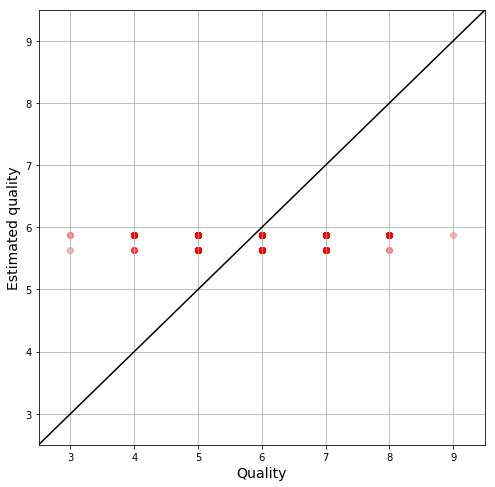

In [32]:
pyplot.figure(figsize(8,8))
pyplot.scatter(y_test, y_test_predictions, color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
plt.xlabel('Quality', fontsize=14)
plt.ylabel('Estimated quality', fontsize=14)

# Другие признаки

На самом деле у нас есть ещё 11 признаков, описывающих химический состав вин:

In [33]:
wine.head()

,Type,Fixed acidity (g/l),Volatile acidity (g/l),Citric acid (g/l),Residual sugar (g/l),Chlorides (g/l),Free sulfur dioxide (mg/l),Total sulfur dioxide (mg/l),Density (g/cm3),pH,Sulphates (g/l),Alcohol (%),quality
937,red,12.0,0.63,0.50,1.40,0.071,6.0,26.0,0.99791,3.07,0.60,10.4,4
2591,white,6.5,0.25,0.27,15.20,0.049,75.0,217.0,0.99720,3.19,0.39,9.9,5
1431,red,7.6,0.43,0.31,2.10,0.069,13.0,74.0,0.99580,3.26,0.54,9.9,6
2638,white,7.5,0.17,0.34,1.40,0.035,13.0,102.0,0.99180,3.05,0.74,11.0,5
2760,white,7.8,0.30,0.29,16.85,0.054,23.0,135.0,0.99980,3.16,0.38,9.0,6


C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


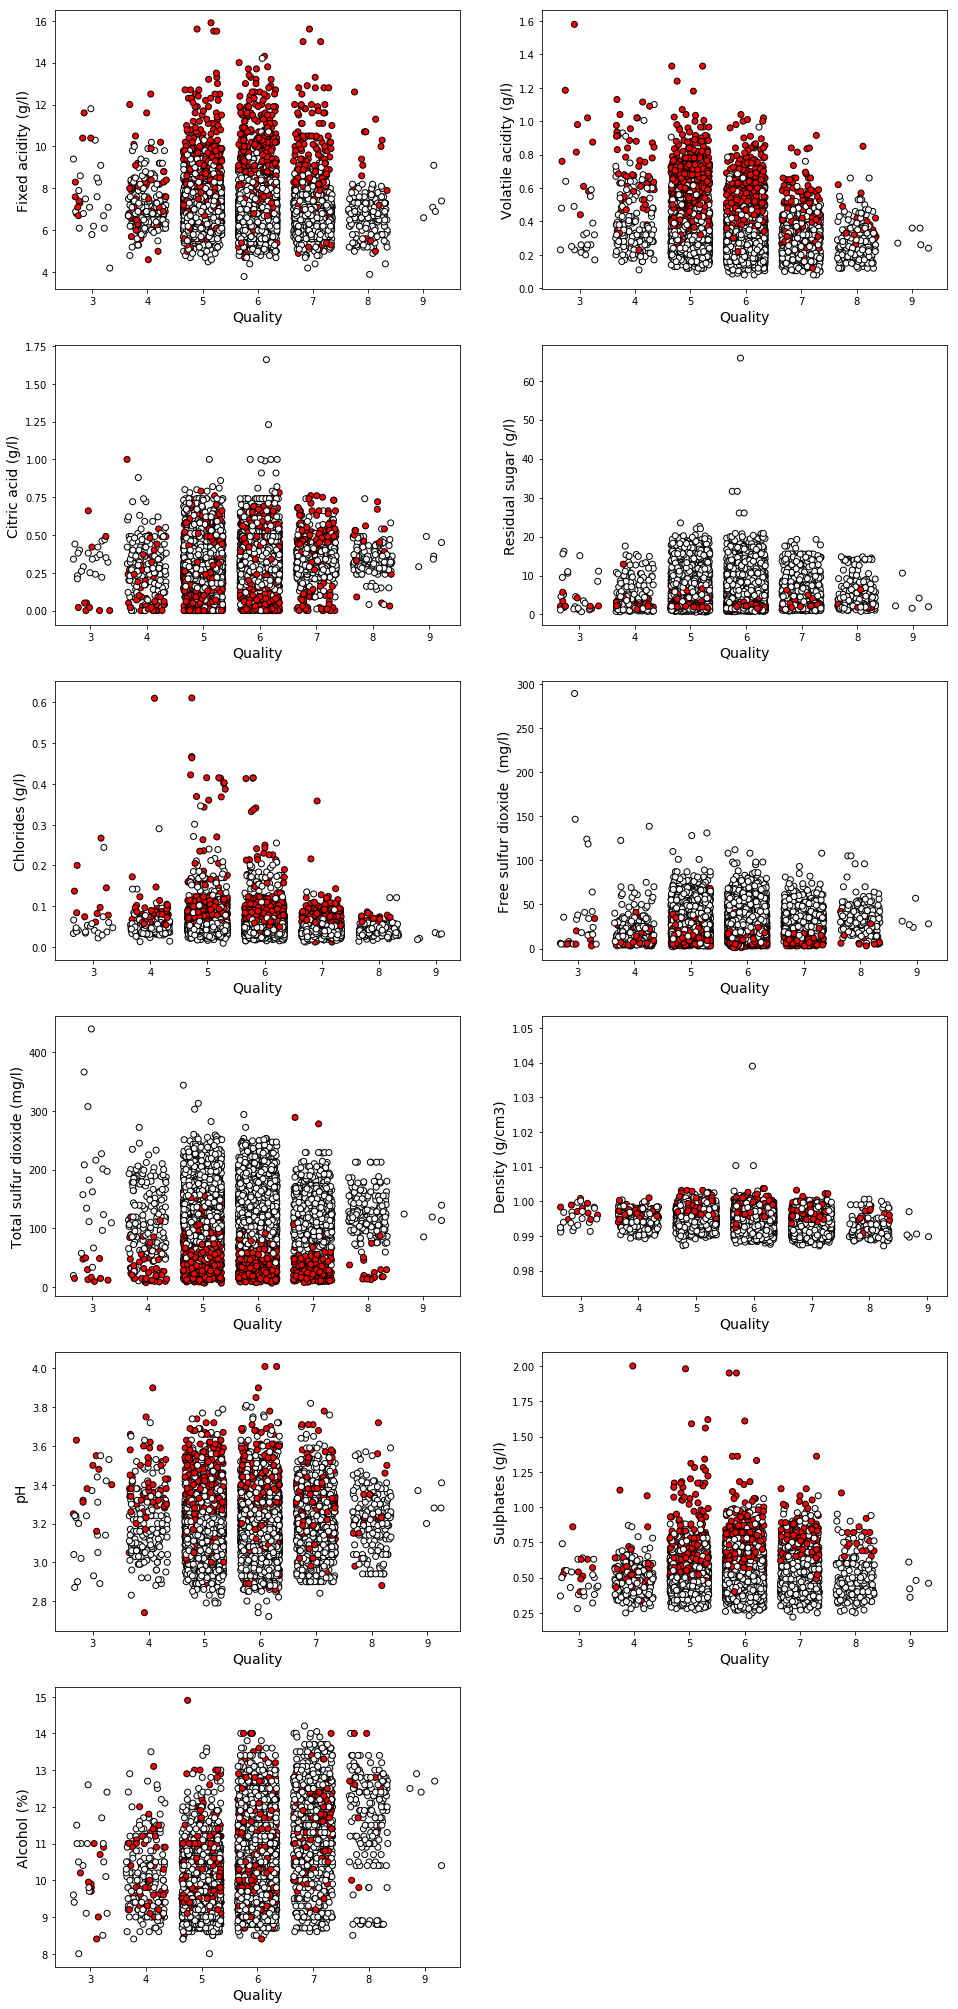

In [34]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

pyplot.figure(figsize(16, 36))
for i in range (1, 12):
    pyplot.subplot(6, 2, i)
    pyplot.scatter(jitter(wine['quality']), wine.ix[:, i], color=wine["Type"], edgecolors="black")
    pyplot.xlabel('Quality', fontsize=14)
    pyplot.ylabel(str(wine.columns[i]), fontsize=14)

Попробуем их учесть при построении прогноза оценок.

## Линейная регрессия

Построим для начала линейную регрессионную модель.

In [37]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Ошибки предсказания существенно уменьшились:

In [38]:
sqrt(mean_squared_error(lm.predict(X_train), y_train))

0.7241697569503659

In [39]:
sqrt(mean_squared_error(lm.predict(X_test), y_test))

0.7578972327800527

Истинные оценки вин и их предсказания линейной моделью:

Text(0, 0.5, 'Estimated quality')

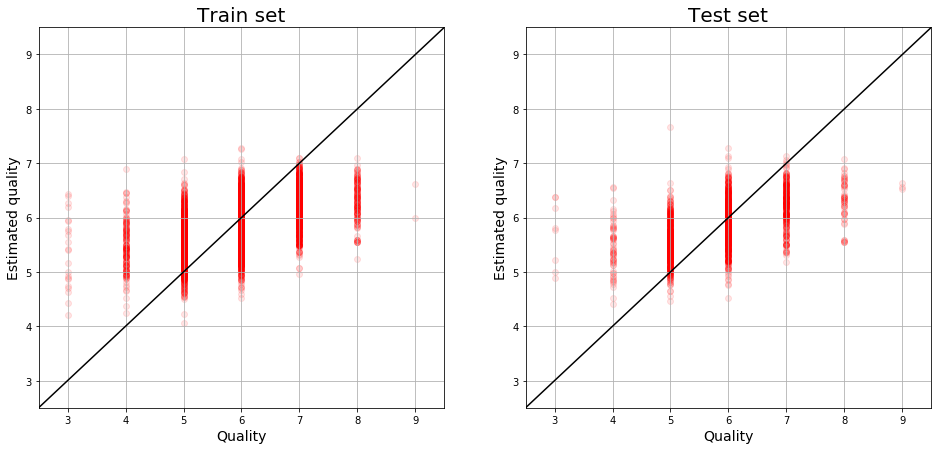

In [40]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, lm.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, lm.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Посчитаем коэффициент детерминации — долю объяснённой моделью дисперсии отклика:

In [41]:
lm.score(X_test, y_test)

0.28682212269732754

## Случайный лес

Построим на обучающей выборке случайный лес:

In [42]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)

In [43]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Качество выросло ещё сильнее, хотя модель и переобучилась:

In [44]:
sqrt(mean_squared_error(rf.predict(X_train), y_train))

0.34929249659874717

In [45]:
sqrt(mean_squared_error(rf.predict(X_test), y_test))

0.6285181823002545

Истинные оценки вин и их предсказания случайным лесом:

Text(0, 0.5, 'Estimated quality')

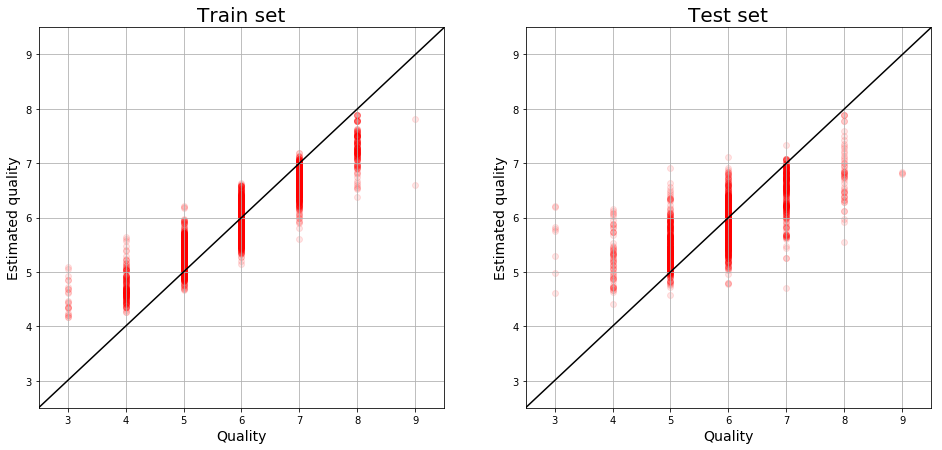

In [46]:
plt.figure(figsize(16,7))
plt.subplot(121)
pyplot.scatter(y_train, rf.predict(X_train), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Train set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

plt.subplot(122)
pyplot.scatter(y_test, rf.predict(X_test), color="red", alpha=0.1)
pyplot.xlim(2.5,9.5)
pyplot.ylim(2.5,9.5)
plot(range(11), color='black')
grid()
pyplot.title('Test set', fontsize=20)
pyplot.xlabel('Quality', fontsize=14)
pyplot.ylabel('Estimated quality', fontsize=14)

Коэффициент детерминации для случайного леса:

In [47]:
rf.score(X_test, y_test)

0.5095294767603336

Сравним ошибки линейной регрессии и случайного леса на тестовой выборке:

C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Difference of absolute errors')

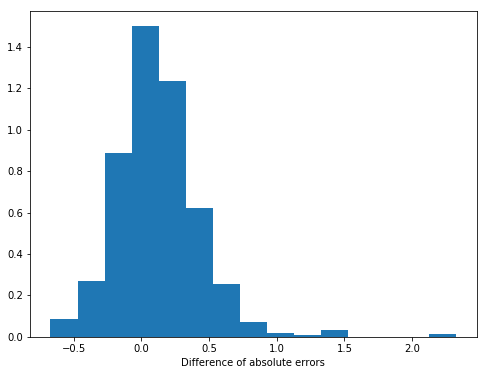

In [48]:
plt.figure(figsize(8,6))
plt.hist(abs(y_test - lm.predict(X_test)) - abs(y_test - rf.predict(X_test)), bins=15, normed=True)
plt.xlabel('Difference of absolute errors')

Различия между средними абсолютными ошибками значимы:

In [49]:
tmeans = sm.CompareMeans(sm.DescrStatsW(abs(y_test - lm.predict(X_test))), 
                         sm.DescrStatsW(abs(y_test - rf.predict(X_test))))

tmeans.ttest_ind(alternative='two-sided', usevar='pooled', value=0)[1]

5.021852731983428e-15

95% доверительный интервал для средней разности абсолютных ошибок:

In [50]:
tmeans.tconfint_diff(alpha=0.05, alternative='two-sided', usevar='pooled')

(0.0942460747116137, 0.156850747384686)

То есть, используя вместо линейной регрессии наш случайный лес, мы предсказываем экспертную оценку в среднем на 0.26-0.30 баллов точнее.

Давайте посмотрим, какие признаки обладают наибольшей предсказательной способностью:

In [70]:
importances = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)))
importances.columns = ['feature name', 'importance']
importances.sort_values(by='importance', ascending=False)

,feature name,importance
11,Alcohol (%),0.284619
2,Volatile acidity (g/l),0.140170
6,Free sulfur dioxide (mg/l),0.084764
10,Sulphates (g/l),0.077700
7,Total sulfur dioxide (mg/l),0.067164
4,Residual sugar (g/l),0.066402
9,pH,0.060499
5,Chlorides (g/l),0.057427
8,Density (g/cm3),0.054611
3,Citric acid (g/l),0.053041


Cильнее всего на экспертную оценку качества вина влияет содержание алкоголя.